Project Progress Report Title:

Team

Name (NetID): Expanded roles and current contributions.

Stephen Cox, ssj63. improved model progress and data handling

Shaz Momin, wzu2. Baseline model.

## Abstract

The goal of this project is to use historical U.S. Department of Agriculture (USDA) National Agricultural Statistics Service (NASS) census data to build a machine learning model that predicts county-level production per commodities for Texas farms.
Using data from the 2012, 2017, and 2022 agricultural censuses, we will develop baseline regression models and apply an improved neural network approach.
We also aim to interpret the model to understand which farming factors most strongly influence yield outcomes.


## Problem Statement

- Farmers in Texas are a very important part of our community. It is important to know what factors can effect the success of our farmers and their product since many people relay on Texas grown crops.

- What factors most deeply effect our farms success and can we predict if our farms will be succesful for the year.

- Benchmarks we will use are Mean Absolute Error, Root Mean Squared Error and R^2. Each of these scores we help us interpret different parts of the models accuracy/precision/recall since this is a regressive model

- The Data comes from US Department of Agriculture - National Agricultural Statistics Service census data which includes many different info points like: yield, land size and fertilizer... 

- Practical Interpretability, we hope to use this model to try and interpret correlations between farming factors and the production per commodities

- What we hope to achieve
    - Build a working NN regressor that predicts county-level production per commodities for Texas using 2012/2017/2022 data.
    - Beat simple baselines (mean and linear reg.) by at least a measurable margin (lower MAE/RMSE).
    - Produce interpretable model explainers (SHAP or partial dependence) showing the most influential

### Expanded explanation, addressing all feedback and what has been learned about the dataset and the task since the project proposal.

Down below is the EDA on the cleaned dataset that we are using. We have discovered multiple issues with the dataset for our goal and have to shift according to our models. The primary issue with this dataset is that for are particular target, yield, many 
counties do not report yield. The issue in this is when pivoting the table by a key using pandas, the pivot drops most NaN columns or columns that would not be fully made. We pivoted our data by counties in Texas, there are only about 170 yield reports out of 762 county reports in the 3 years of census data that we are using. 

## Dataset

*Data description and visualization (figures/tables as relevant).*

*Observations of distributions, correlations, outlier detection, and data cleaning.*

In [13]:
#Load files for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


df_raw = pd.read_csv("data/Texas_AgCensus_2012_2017_2022.csv")
cleaned_df = pd.read_csv("data/cleaned_COUNTY_data.csv")

print("RAW DATA SHAPE:", df_raw.shape)
print("Cleaned DATA SHAPE:", cleaned_df.shape)


C:\Users\Shaz\AppData\Local\Temp\ipykernel_88168\2153419850.py:12: DtypeWarning: Columns (18,21,29,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/Texas_AgCensus_2012_2017_2022.csv")


RAW DATA SHAPE: (1240157, 40)
Cleaned DATA SHAPE: (762, 2178)


In [7]:
#NaN values for unreported numbers from farms
cleaned_df = cleaned_df.fillna(0)
cleaned_df.drop("Unnamed: 0",axis=1,inplace=True)

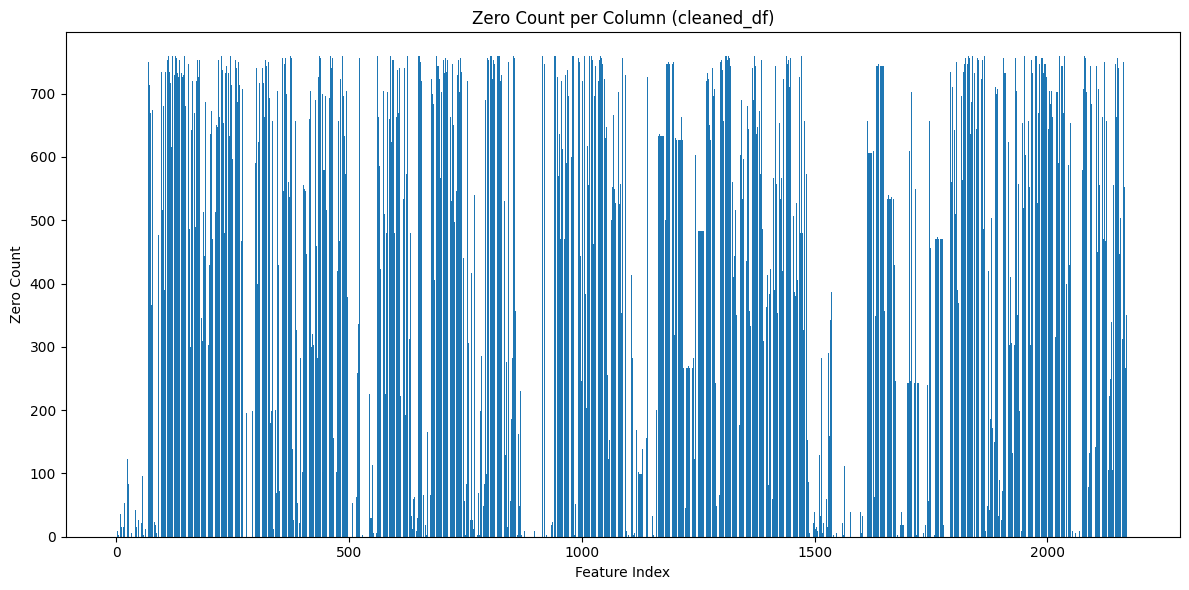

      index                                        column  zero_count
0         0                                          YEAR           0
1         1                            AGLAND_AGLANDACRES           9
2         2               AGLAND_AGLANDCROPINSURANCEACRES           9
3         3  AGLAND_AGLANDCROPINSURANCENUMBEROFOPERATIONS           0
4         4                    AGLAND_AGLANDCROPLANDACRES           3
...     ...                                           ...         ...
2172   2172       WHEAT_WHEATWINTERPRODUCTIONMEASUREDINBU         270
2173   2173             WOOL_WOOLOPERATIONSWITHPRODUCTION          96
2174   2174               WOOL_WOOLPRODUCTIONMEASUREDINLB         243
2175   2175                      WOOL_WOOLSALESMEASUREDIN         609
2176   2176                                   COUNTY_NAME           0

[2177 rows x 3 columns]


In [8]:

# --- Zero counts ---
# Compute zero counts
zero_counts = (cleaned_df == 0).sum()

# Use numeric indices instead of long labels
x = range(len(zero_counts))

plt.figure(figsize=(12,6))
plt.bar(x, zero_counts.values)
plt.title("Zero Count per Column (cleaned_df)")
plt.xlabel("Feature Index")
plt.ylabel("Zero Count")
plt.tight_layout()
plt.show()

#print index -> column lookup
lookup = pd.DataFrame({
    "index": x,
    "column": zero_counts.index,
    "zero_count": zero_counts.values
})
print(lookup)


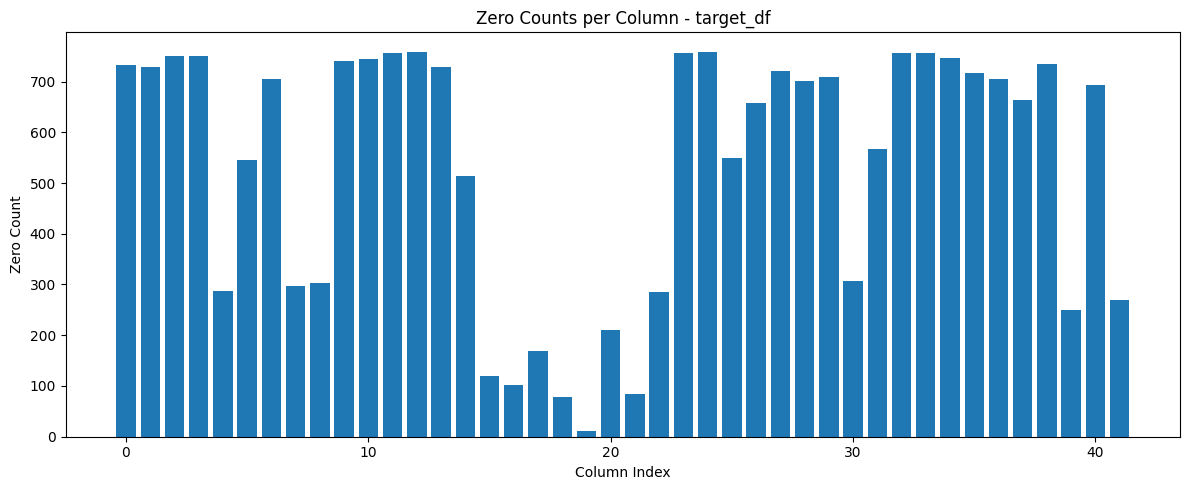

In [9]:
#get target crops from txt file
with open("models/croptarget.txt") as f:
    crops = [line.strip() for line in f.readlines() if line.strip()]


#find columns based on <crop> _ PRODUCTION for target df
target_cols = [
    col for col in cleaned_df.columns
    if col.split("_")[0] in crops and "PRODUCTION" in col.upper()
]

target_df = cleaned_df[target_cols]

#get zero counts
zero_counts_target = (target_df == 0).sum()

plt.figure(figsize=(12, 5))
plt.bar(range(len(zero_counts_target)), zero_counts_target.values)
plt.xlabel("Column Index")
plt.ylabel("Zero Count")
plt.title("Zero Counts per Column - target_df")
plt.tight_layout()
plt.show()


In [10]:
print(target_df.columns[19])

HAY_HAYPRODUCTIONMEASUREDINTONS


### Insights gained from EDA that inform next steps.

A better target for us is production of crops. The yield of a crop is derived from the amount of production so the impact of the models will stay the same. Additionally every county is required to report production for each good that they produce meaning that we will have plenty of options/crops to choose to design our model off of. Furthermore, if we need more samples for our models the possibility of expanding to nearby states has been considered since many southern states grow similar crops.

The general takeaway is that most of the data that we have at least for our targets crops. Most farms don't grow every crop so most models will not work unless a very large amount of samples for each crop is present. For our specific crop, the best to use would be hay since only 12 samples are 0 meaning only 4 counties in Texas do not grow hay.


# Methodology

## Baseline method implementation

Description of baseline model(s) attempted.

Results: quantitative metrics and qualitative observations.

Discussion of results: What do baseline results reveal about the problem/data?

Visual or tabular summaries as appropriate.


The baseline models that were attempted are Linear Regression and Random Forest Regression. Linear Regression model was created using the year as a sole feature.

Results: 
Quantitative:
R^2 Mean: -0.0264
R^2 Range: -0.0871 to -0.0035
RMSE Mean: 19,230 Tons

Discussion of the Results:
Linear Regression is the best for almost all the Variables. R^2 shows a need for enviromental features.

In [14]:
production_cols = [col for col in cleaned_df.columns if 'PRODUCTION' in col]
hay_cols = [col for col in production_cols if 'HAY' in col] 
# Hay production model
hay_results = {}

for target_col in hay_cols:
    print(f"\nTraining model for target: {target_col}")
    
    display_name = target_col.replace('PRODUCTION', '').replace('MEASURED IN', ' ').strip()
    print(f"\n{display_name}")
    
    data = cleaned_df[[target_col, 'YEAR']].copy()
    data = data.dropna(subset=[target_col])
    
    if len(data) < 30:
        print(f"Insufficient data (need ≥30)")
        continue
    
    x = data[['YEAR']].values
    y = data[target_col].values
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_r2 = r2_score(y_test, lr.predict(X_test))
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
    
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_r2 = r2_score(y_test, rf.predict(X_test))    
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
    
    best_r2 = max(lr_r2, rf_r2)
    best_model = lr if lr_r2 >= rf_r2 else rf
    
    x_2027 = np.array([[2027]])
    pred_2027 = best_model.predict(x_2027)[0]
    histo_avg = y_train.mean()
    growth_rate = ((pred_2027 - histo_avg) / histo_avg) * 100
    hay_results[display_name] = {
        'target_col': target_col,
        'data_points': len(data),
        'lr_r2': lr_r2,
        'rf_r2': rf_r2,
        'best_r2': best_r2,
        'best_model': 'RF' if rf_r2 > lr_r2 else 'LR',
        'lr_rmse': lr_rmse,
        'rf_rmse': rf_rmse,
        'historical_avg': histo_avg,
        'forecast_2027': pred_2027,
        'growth_rate': growth_rate,
        'lr_obj': lr,
        'rf_obj': rf
    }
    
    print(f"  LR R²: {lr_r2:.4f} | RMSE: {lr_rmse:,.0f}")
    print(f"  RF R²: {rf_r2:.4f} | RMSE: {rf_rmse:,.0f}")
    print(f"  Best: {hay_results[display_name]['best_model']} (R² = {best_r2:.4f})")


Training model for target: HAYHAYLAGE_HAYHAYLAGEPRODUCTIONMEASUREDINTONSDRYBASIS

HAYHAYLAGE_HAYHAYLAGEMEASUREDINTONSDRYBASIS
  LR R²: -0.0199 | RMSE: 40,073
  RF R²: -0.0224 | RMSE: 40,122
  Best: LR (R² = -0.0199)

Training model for target: HAYLAGE_HAYLAGEALFALFAPRODUCTIONMEASUREDINTONS

HAYLAGE_HAYLAGEALFALFAMEASUREDINTONS
  LR R²: -0.0549 | RMSE: 7,335
  RF R²: -0.0624 | RMSE: 7,361
  Best: LR (R² = -0.0549)

Training model for target: HAYLAGE_HAYLAGEEXCLALFALFAPRODUCTIONMEASUREDINTONS

HAYLAGE_HAYLAGEEXCLALFALFAMEASUREDINTONS
  LR R²: -0.0339 | RMSE: 18,324
  RF R²: -0.0340 | RMSE: 18,324
  Best: LR (R² = -0.0339)

Training model for target: HAYLAGE_HAYLAGEPRODUCTIONMEASUREDINTONS

HAYLAGE_HAYLAGEMEASUREDINTONS
  LR R²: -0.0871 | RMSE: 9,639
  RF R²: -0.0912 | RMSE: 9,657
  Best: LR (R² = -0.0871)

Training model for target: HAY_HAYALFALFAPRODUCTIONMEASUREDINTONS

HAY_HAYALFALFAMEASUREDINTONS
  LR R²: -0.0113 | RMSE: 5,930
  RF R²: -0.0139 | RMSE: 5,937
  Best: LR (R² = -0.0113)

## Improvements and other methods implementation

*Feature engineering, feature selection, and high dimensionality mitigation.*

The feature engineering, feature selection and high dimensionality mitigation that we are using boils down to three different processes: Correlation filtering, RF regressor and PCA

Before, we managed leakage first for the model removing any columns that may have had our targets or overly correlated data in it to prevent overfitting.

| Concept                     | Correlation Filtering                                              | Random Forest Regressor                                            | PCA                                                                  |
|-----------------------------|--------------------------------------------------------------------|---------------------------------------------------------------------|----------------------------------------------------------------------|
| **Feature Engineering**     | Builds cleaner relationships that correlations can detect          | Gives RF clearer nonlinear patterns to learn                       | Produces more meaningful variance directions for PCA                |
| **Feature Selection**       | Removes weak or redundant features using correlation thresholds    | Uses RF feature importance to keep only top predictors              | Removes noise so PCA learns from high-quality inputs                |
| **High-Dimensionality Mitigation** | Quickly eliminates redundant or low-signal features in large datasets | Prevents RF from splitting on noise or overfitting in high-dim data | PCA directly reduces dimensionality into dense, informative components |



The improved model that we are using over our baseline is a shallow neural network. 
The benefits of using a NN over mean predictor and linear regression is present in handling colinearity and high dimensionality better.
There are a few risks since our transformed data is not huge NN have a higher risk of overfitting additionally they take longer to train and are uninterperatable.

For current implementation we will include the code for the feature selection and the model for the NN currently. 

A few issues have been primarily rooted from the development of the improved model, mainly the broadness of our goal. The 42 targets is too much for the shallow NN and we don't have enough data to for convergence.
A focused crop like hay will be persued and trained. Once again, if more data is needed. We will expand our regions to adjacent states counties including Texas.



### Correlation filtering
```py
corr_matrix = pd.DataFrame(X).corr().abs()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Drop them
X_reduced = X.drop(columns=to_drop)
print("Dropped highly correlated features:", len(to_drop))

# RF Regressor
```python
from sklearn.ensemble import RandomForestRegressor

#Use the correlation-cleaned feature matrix
X_corrclean = X_reduced   # (after leakage removal + correlation filtering)

#Initialize importance vector with correct length
importances = np.zeros(X_corrclean.shape[1])

#Loop over each production target (each crop)
for i in range(y.shape[1]):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_corrclean, y.iloc[:, i])
    importances += rf.feature_importances_

#Average importance across all targets
importances /= y.shape[1]

#Select top 200 most important features
top_idx = np.argsort(importances)[-200:]

#Reduce dataset
X_reduced = X_corrclean.iloc[:, top_idx]
```

*Note: This will change when focusing on a single crop production*


# PCA
```python
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)


from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_scaled)

```
*Note: scale/normalize values before pca is required*


# Shallow NN Model

```python
input_dim = X_pca.shape[1]
output_dim = y_train.shape[1]



model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(42)  # one output per crop
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)


# Metrics Gathering

```python
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()
```
*Note: with current target and data model does not converge*

## Last week goals:
Stephen: work on improved model on a more specific target
Shaz: working the baseline models.

## Teaming Strategy

Communicate through discord and meet once a week

## Individual team member contributions.



Name	Contribution	Section(s) Authored / Tasks Completed
Team Member	What where how	
(Add additional rows as needed for each member.)

Stephen Cox, Improvement model and data handling, partial EDA
Shaz Momin, completed baseline models.

## Mitigation Plan

We will drop one of the models and do a deeper analysis

## Key milestones or tasks to be completed by project end.

Finish models, analyze models. Make presentation and final report.

## Who is responsible for each task?

Stephen: improvement model
Shaz: Baseline model
Prabesh: analysis of models

All: presentation and final report

### Timeline/checkpoints to ensure on-time submission.

Models finished by Tuesday, presentation with some analysis wednesday and thursday morning. Final tuning and report before deadline.


## What if you fail?

Baseline: more specific target as a backup
Improvement: analyze why the improved model failed

group work: submit what we have. finish as much as possible